Consider the 2D heat transient equation on a square domain:

\begin{equation}
\rho c\frac{\partial T}{\partial t} = k\left(\frac{\partial^2 T}{\partial x^2} + \frac{\partial^2 T}{\partial y^2}\right), \quad (x, y)\in [0, L_x]\times[0, L_y], \quad t \ge 0
\end{equation}

In this problem, you will model the 2D domain subjected to a moving Gaussian heat flux along the top surfce. The heat flux mimics the heat input that comes from a focused laser beam (such as you might encounter in e.g. welding or 3D printing applications).

$~$

![image-2.png](attachment:image-2.png){width=400px style="display: block; margin: 0 auto"}

$~$

1. **Initial conditions:** The plate is initially at a temperature of $T = \bar{T}$ everywhere in the domain. This corresponds to the initial condition $$T(x, y, 0) = \bar{{T}}$$

$~$

2. **Fixed temperature on sides and bottom:** Throughout the heating process, the temperature on the top and bottom edges is fixed at $T = \bar{T}$ (including the top left and right corners at $(0, L_y)$ and $(L_x, L_y)$). This corresponds to the boundary conditions $$T(0, y, t) = \bar{{T}} = T(L_x, y, t) = T(x, 0, t) = \bar{{T}}$$

$~$

3. **Laser flux on top:** At time $t=0$, the laser turns on. The heat input from the laser is given by the funciton $q_{L}(x,t)$. This flux is applied at the top surface of the plate at $y = L_y$. Mathematically, we have the boundary condition $$k\frac{\partial T}{\partial y}(x, L_y, t) = q_{L}(x, t)$$ where $k$ is the thermal conductivity of the material and $q_{L}(x,t)$ is the time-dependent laser flux function.

$~$

4. **Laser beam flux and motion** The laser beam travels with a constant velocity $v_L$ in the $+x$ direction. It begins at a poisition of $x_start$ and ends at a position of $x_end$. Therefore, the laser position as a function of time is given by $$x_{L}(t) = x_{start} + v_{L}t$$ Upon reaching the end of the domain, the laser turns off and the flux is zero. Accounting for the Gaussian profile of the heat flux, $q_{L}(x,t)$ can be written as:
   
   $$q_{L}(x, t) = \begin{cases} \frac{P}{\sqrt{2\pi}w}\exp{-\frac{(x - x_{L}(t))^2}{2w^2}} & 0 \le t \le \frac{x_{end} - x_{start}}{v_{L}} \\ \\ 0 & \text{otherwise} \end{cases}$$

   $~$
    
   where $P$ is the laser power, $w$ is the laser spot size, and $x_{L}(t)$ is the time dependent position ($x$ coordinate) of the laser beam on the top surface.

$~$

5. **After laser shut off:** Your code should allow the simulation to continue after the laser has shut off. In this case, the flux funciton on top is just $q_{L}(x, t) = 0$, an insulated top boundary.

$~$

You will implement the function ```laser_heat_2d``` which solves this problem using constant (but not necessarily equal) grid spacing $\Delta x$ and $\Delta y$ in each direction, constant time step $\Delta t$ with the forward Euler method for time integration, and a first-order appoximation of the derivative for the laser flux condition on the top boundary of the domain. 

One of the outputs of your function is ```dt_max```, which is the maximum allowable time step for the forward Euler method based on the modified wavenumber analysis of the transient heat equation that we covered in class. This value is

\begin{equation}
    \Delta t_{max} = \frac{1}{2\alpha\left(\frac{1}{\Delta x^2} + \frac{1}{\Delta y^2}\right)}
\end{equation}

where $\alpha = \frac{k}{\rho c}$ is the thermal diffusivity.

$~$

Below is a list of input variables into the function:

| Name     | Type                          | Description                                                                                             |
|----------|-------------------------------|---------------------------------------------------------------------------------------------------------|
| coord_lim| 2D numpy array (dtype=float)  | The x and y limits of the domain (coord_lim[0,:] = [xmin, xmax], coord_lim[1,:] = [ymin, ymax])         |
| N_array  | 1D numpy array (dtype=int)    | Array containing values of Nx and Ny, N_array = [Nx, Ny]. There are Nx + 1 and Ny + 1 grid points in each direction |
| t_end    | float                         | The simulation end time                                                                                 |
| Nt       | int                           | Number of time steps to take. There are Nt + 1 total time points in the simulation.                     |
| rho      | float                         | Mass density of the material ρ.                                                                         |
| c        | float                         | Specific heat capacity of the material c.                                                                |
| k        | ```float```                         | Thermal conductivity of the material k.                                                                  |
| P        | float                         | The laser power.                                                                                        |
| w        | float                         | The laser spot size                                                                                     |
| x_start  | float                         | The x-coordinate on the top edge where the laser begins.                                                 |
| x_end    | float                         | The x-coordinate on the top edge where the laser ends and deactivates.                                   |
| vL       | float                         | The laser velocity.                                                                                     |
| T_bar    | float                         | The temperature $\bar{T}$ which is the IC as well as the BC for the left, bottom and the right edges.          |

$~$

Below is a list of outputs from the function:

| Name          | Type           | Description                                                                                                 |
|---------------|----------------|-------------------------------------------------------------------------------------------------------------|
| dt_max        | float          | Maximum allowable time step for the forward Euler method for the given input parameters                     |
| x             | 1D numpy array | List of all of the Nx + 1 grid-points                                                                       |
| y             | 1D numpy array | List of all of the Ny + 1 grid-points                                                                       |
| t             | 1D numpy array | List of all of the Nt + 1 time points in the simulation                                                     |
| T             | 3D numpy array | T[i,j,n] stores the solution T(xi, yj, tn). The array is (Nx + 1) x (Ny + 1) x (Nt + 1) in size             |
| laser_heat_2d | function       | Function to conduct the laser scanning simulation.                                                          |


The function skeleton is provided below. The grader will test your function for different grid-sizes, time discretization parameters, laser parameters, and material properties ensure your function can process general inputs.

## 1.1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.gridspec import GridSpec


def laser_heat_2d(
    coord_lim, N_array, t_end, Nt, rho, c, k, P, w, x_start, x_end, vL, T_bar
):
    xmin, xmax = coord_lim[0, :]
    ymin, ymax = coord_lim[1, :]
    Nx, Ny = N_array

    # Calculating grid spacings and time step
    dx = (xmax - xmin) / Nx
    dy = (ymax - ymin) / Ny
    dt = t_end / Nt

    # Thermal diffusivity
    alpha = k / (rho * c)  # m^2/s

    # Maximum allowable time step for stability
    dt_max = 1 / (2 * alpha * (1 / dx**2 + 1 / dy**2))

    # Grid initialization
    x = np.linspace(xmin, xmax, Nx + 1)
    y = np.linspace(ymin, ymax, Ny + 1)
    t = np.linspace(0, t_end, Nt + 1)

    # Initial condition
    T = np.full((Nx + 1, Ny + 1, Nt + 1), T_bar, dtype=float)

    # Time integration using Forward Euler
    for n in range(Nt):
        # Temperature update for interior points
        # use vectorized 2D Laplacian calculation
        T_xx = (
            T[2 : Nx + 1, 1:Ny, n] - 2 * T[1:Nx, 1:Ny, n] + T[0 : Nx - 1, 1:Ny, n]
        ) / dx**2

        T_yy = (
            T[1:Nx, 2 : Ny + 1, n] - 2 * T[1:Nx, 1:Ny, n] + T[1:Nx, 0 : Ny - 1, n]
        ) / dy**2

        T[1:Nx, 1:Ny, n + 1] = T[1:Nx, 1:Ny, n] + alpha * dt * (T_xx + T_yy)

        # Laser flux on top boundary
        if t[n] <= (x_end - x_start) / vL:
            xL = x_start + vL * t[n]
            qL = (
                P
                / (np.sqrt(2 * np.pi) * w)
                * np.exp(-((x[1:Nx] - xL) ** 2) / (2 * w**2))
            )

        else:  # After laser shuts off
            qL = 0

        T[1:Nx, Ny, n + 1] = T[1:Nx, Ny - 1, n + 1] + dy * qL / k

        # Boundary conditions for sides and bottom
        T[:, 0, n + 1] = T_bar  # Bottom
        T[0, :, n + 1] = T_bar  # Left
        T[Nx, :, n + 1] = T_bar  # Right

    return dt_max, x, y, t, T

## 1.2

In [34]:
# Simulation parameters
Nx = 250
Ny = 50
t_end = 2
dt = 5e-4
Nt = int(t_end / dt)
Lx = 0.05  # m
Ly = 0.01  # m
T_bar = 25.0  # C
coord_lim = np.array([[0, Lx], [0, Ly]])

# Material parameters
k = 48  # W/m/C
rho = 7900  # kg/m^3
c = 470  # W/kg C

# Laser parameters
w = 0.004  # m
P = 5000  # W
x_start = 0.1 * Lx  # m
x_end = 0.9 * Lx  # m
vL = 0.02  # m/s

dt_max, x, y, t, T = laser_heat_2d(
    coord_lim, np.array([Nx, Ny]), t_end, Nt, rho, c, k, P, w, x_start, x_end, vL, T_bar
)

In [35]:
from matplotlib import animation
from IPython.core.display import HTML

fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection="3d")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("T")
ax.set_title("Temperature")
ax.set_zlim(T_bar, np.max(T) * 1.1)
surf = ax.plot_surface(x[:, None], y[None, :], T[:, :, 0], cmap=cm.coolwarm)
plt.close()


def animate(i):
    ax.clear()
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("T")
    ax.set_title(f"Temperature at t = {t[i]:.2f}")
    ax.set_zlim(T_bar, np.max(T) * 1.1)
    surf = ax.plot_surface(x[:, None], y[None, :], T[:, :, i], cmap=cm.coolwarm)
    return surf


frames = np.arange(0, Nt + 1, 40)
anim = animation.FuncAnimation(fig, animate, frames=frames, interval=100)
HTML(anim.to_html5_video())

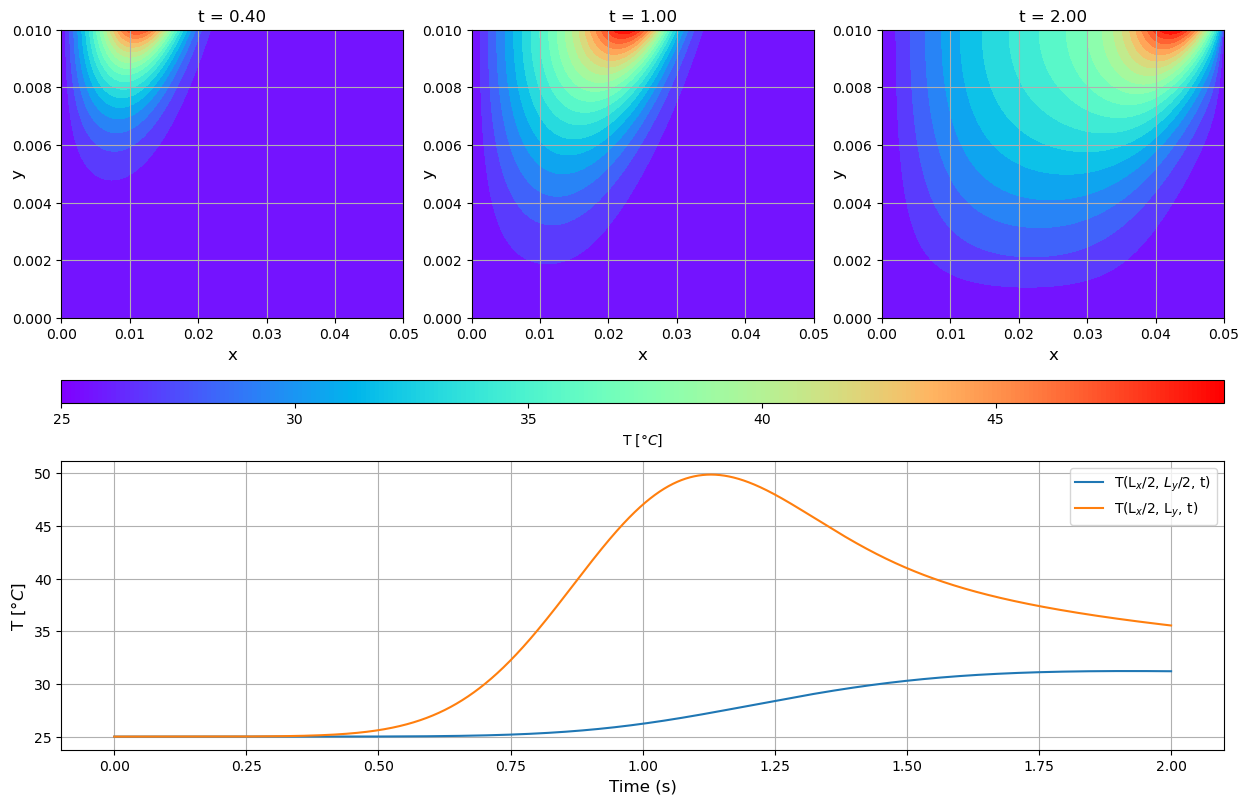

In [100]:
X, Y = np.meshgrid(x, y)
contour_regions = np.linspace(T_bar, np.max(T.flatten()), 21)
n1, n2, n3 = int(0.2 * Nt), int(0.5 * Nt), int(Nt)
n = [n1, n2, n3]

gs = GridSpec(2, 3, height_ratios=[1, 0.7])

fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
axs = [ax1, ax2, ax3]

for i, n in enumerate([n1, n2, n3]):
    axs[i].contourf(X, Y, T[:, :, n].T, levels=contour_regions, cmap="rainbow")
    axs[i].set_xlabel("x", size=12)
    axs[i].set_ylabel("y", labelpad=-10, size=12)
    axs[i].set_title(f"t = {t[n]:.2f}", size=12)
    axs[i].grid()

norm = cm.colors.Normalize(vmin=np.min(T), vmax=np.max(T))
cbar = fig.colorbar(
    cm.ScalarMappable(norm=norm, cmap="rainbow"),
    ax=axs,
    orientation="horizontal",
    pad=0.15,
    aspect=50,
)
cbar.set_label("T $[\degree{C}]$")

center_temp = T[Nx // 2, Ny // 2, :]
top_center_temp = T[Nx // 2, Ny, :]

ax4 = fig.add_subplot(gs[1, :])
ax4.plot(t, center_temp, label="T(L$_{x}$/2, $L_{y}$/2, t)")
ax4.plot(t, top_center_temp, label="T(L$_{x}$/2, L$_{y}$, t)")
ax4.grid()
ax4.legend()
ax4.set_xlabel("Time (s)", size=12)
ax4.set_ylabel("T $[\degree{C}]$", size=12)
pos = ax4.get_position()
ax4.set_position([pos.x0, pos.y0 + 0.05, pos.width, pos.height])

## 1.3

In [101]:
P = np.array([1250.0, 2500.0, 3750.0, 5000.0, 6250.0, 7500.0])
vL = np.array([0.01, 0.02, 0.04, 0.08])
Lx = 0.05  # m
Ly = 0.01  # m
Nx = 100
Ny = 20
dt = 1e-3
t_end = 2
Nt = int(t_end / dt)
T_bar = 25.0  # C
w = 0.004  # m
x_start = 0.1 * Lx  # m
x_end = 0.9 * Lx  # m
coord_lim = np.array([[0, Lx], [0, Ly]])
k = 48  # W/m/C
rho = 7900  # kg/m^3
c = 470  # W/kg C

max_temps = np.zeros((len(vL), len(P)))

for i, v in enumerate(vL):
    for j, p in enumerate(P):
        dt_max, x, y, t, T = laser_heat_2d(
            coord_lim,
            np.array([Nx, Ny]),
            t_end,
            Nt,
            rho,
            c,
            k,
            p,
            w,
            x_start,
            x_end,
            v,
            T_bar,
        )
        max_temps[i, j] = np.max(T)

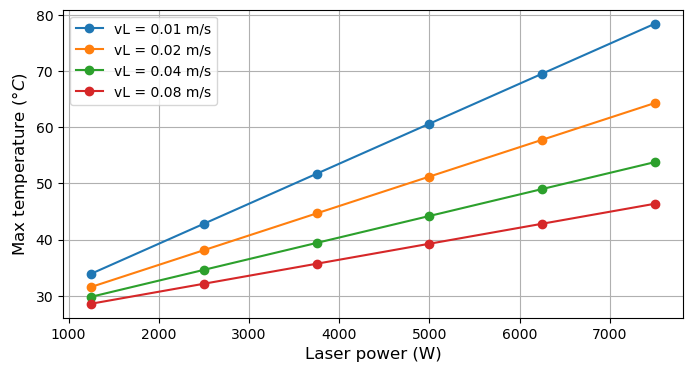

In [102]:
fig, ax = plt.subplots(figsize=(8, 4))

for i, v in enumerate(vL):
    ax.plot(P, max_temps[i, :], label=f"vL = {v} m/s", marker="o")

ax.set_xlabel("Laser power (W)", size=12)
ax.set_ylabel("Max temperature ($\degree{C}$)", size=12)
ax.grid()
ax.legend()
plt.show()

## 2.1

In [103]:
from utilities import *
from fea_functions import *


def tri3_elem_arrays(nen, xe, ye, k, Q):
    """Compute element stiffness matrix and force vector for 3 node linear triangle with constant body heat load.

    Parameters
    ----------
    nen : int
        Number of nodes per element.
    xe : array_like
        Element x coordinates.
    ye : array_like
        Element y coordinates.
    k : float
        Thermal conductivity.
    Q : float
        Constant body heat load.

    Returns
    -------
    ke : array_like
        Element stiffness matrix.
    fe : array_like
        Element force vector.
    """

    y23 = ye[1] - ye[2]
    x32 = xe[2] - xe[1]
    x13 = xe[0] - xe[2]
    x21 = xe[1] - xe[0]
    y13 = ye[0] - ye[2]
    x23 = xe[1] - xe[2]
    y32 = ye[2] - ye[1]
    y21 = ye[1] - ye[0]

    A = 0.5 * np.abs(x13 * y23 - y13 * x23)

    B = np.array(
        [
            [x32, x13, x21],
            [y32, y13, y21],
        ]
    )

    ke = k * B.T @ B / (4 * A)
    fe = Q * A / 3 * np.ones(nen)

    return ke, fe


def tri3_assemble_global_arrays(numnp, numel, nen, p, LM, k, Q):
    """
    Assemble global stiffness matrix and force vector for 3 node linear triangle with constant body heat load.

    Parameters
    ----------
    numnp : int
        Number of nodes in the mesh.
    numel : int
        Number of elements in the mesh.
    nen : int
        Number of nodes per element.
    p : array_like
        Nodal coordinates, array of shape (numnp, 2)
    LM : array_like
        Element connectivity, array of shape (nen, numel)
    k : float
        Thermal conductivity.
    Q : float

    """
    K = np.zeros((numnp, numnp))
    F = np.zeros(numnp)
    for i_elem in range(numel):
        node_indices = LM[:, i_elem] - 1
        xe = p[node_indices, 0]
        ye = p[node_indices, 1]
        ke, fe = tri3_elem_arrays(nen, xe, ye, k, Q)
        for i_local, i_global in enumerate(node_indices):
            F[i_global] += fe[i_local]
            for j_local, j_global in enumerate(node_indices):
                K[i_global, j_global] += ke[i_local, j_local]

    return K, F


def tri3_apply_BCs(nodeFlag, To, Ti, K, F):
    """
    Apply Dirichlet boundary conditions to the global stiffness matrix and force vector.


    Parameters
    ----------
    nodeFlag : array_like
        Boundary condition codes for each node.
    To : float
        Outer boundary temperature.
    Ti : float
        Inner boundary temperature.
    K : array_like
        Global stiffness matrix.
    F : array_like
        Global force vector.

    Returns
    -------
    K : array_like
        Modified global stiffness matrix.
    F : array_like
        Modified global force vector.
    """
    for i, flag in enumerate(nodeFlag):
        if flag == 1:
            K[i, :] = 0
            K[i, i] = 1
            F[i] = To
        elif flag == 2:
            continue
        elif flag == 3:
            K[i, :] = 0
            K[i, i] = 1
            F[i] = Ti

    return K, F


def solve_fea_heat2d(p, LM, nodeFlag, k, Q, To, Ti):
    """
    Solve 2D heat conduction problem using FEA.

    Parameters
    ----------
    p : array_like
        Nodal coordinates, array of shape (numnp, 2)
    LM : array_like
        Element connectivity, array of shape (nen, numel)
    nodeFlag : array_like
        Boundary condition codes for each node, array of shape (numnp,)
    k : float
        Thermal conductivity.
    Q : float
        Constant body heat load.
    To : float
        Outer boundary temperature.
    Ti : float
        Inner boundary temperature.

    Returns
    -------
    T : array_like
        Nodal temperatures, array of shape (numnp,)
    """

    numnp, _ = p.shape
    _, numel = LM.shape
    nen = LM.shape[0]
    K, F = tri3_assemble_global_arrays(numnp, numel, nen, p, LM, k, Q)
    K, F = tri3_apply_BCs(nodeFlag, To, Ti, K, F)
    T = np.linalg.solve(K, F)

    return T

## 2.2

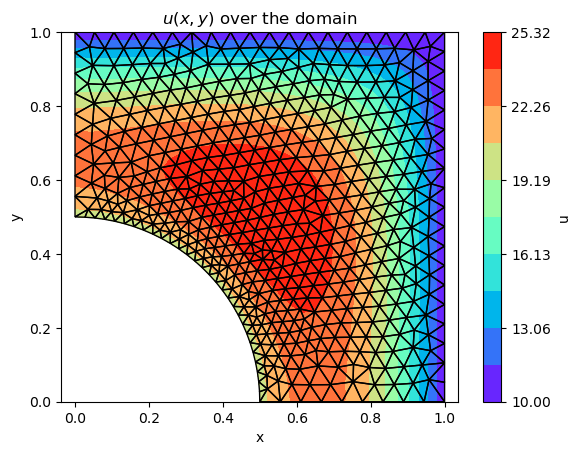

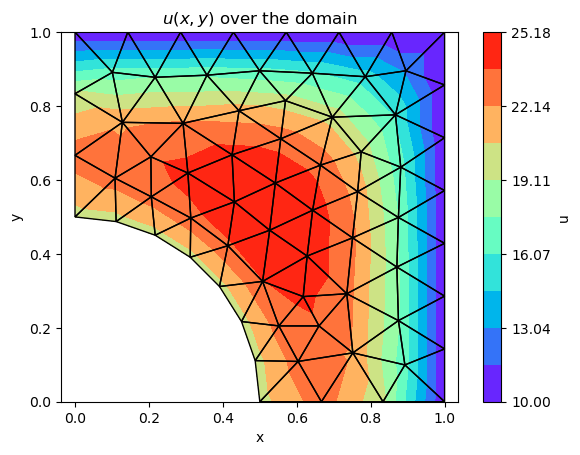

In [104]:
filename = "fine.msh"
p, LM, nodeFlag = msh_reader_2D(filename)
k = 1
# Conductivity
Q = 200  # Body heating term
To = 10  # Dirichlet temperature on the straight edges.
Ti = 20  # Dirichlet condition on the arc.
T = solve_fea_heat2d(p, LM, nodeFlag, k, Q, To, Ti)

# Plot the contour of the solution field T
plot_solution_contour(LM.shape[1], p, LM, T)

filename = "coarse.msh"
p, LM, nodeFlag = msh_reader_2D(filename)
T = solve_fea_heat2d(p, LM, nodeFlag, k, Q, To, Ti)
plot_solution_contour(LM.shape[1], p, LM, T)